# Working with Large Data Sources in S3

Today we're going to be working with a large public dataset that is hosted in S3: the [NYC Taxi dataset](https://registry.opendata.aws/nyc-tlc-trip-records-pds/) (copied to our `css-uchicago` public bucket for your use in this class). We could theoretically download this data and work with it locally, but it is enormous and it is not practical to query and subset it on a local machine. It makes sense to work with the data in the AWS cloud, where it already lives. To this end, we will use Python's `boto3` library to run AWS Athena SQL queries on the data. With these resources, we can begin to access and understand these large datasets in a serverless capacity, without needing to set up standalone database servers. We'll explore formal large-scale database solutions in our next class and further methods for analyzing and fitting models on large-scale data in Weeks 7 and 8 when we learn more about Spark and Dask, but this should whet your appetite and help you see how you can use `boto3` to do large-scale cloud computing tasks within a Jupyter notebook.

If you haven't already, please install the `boto3` package (this can be achieved by running `pip install boto3`). The package will allow you to work with AWS resources using the credentials you have provided as a part of your AWS CLI configuration. So, you should confirm that these credentials are correct (recall that your AWS Academy session token changes every 4 hours) in order to ensure the code runs.

Note: There also seems to be an error for recent `boto3` installations in instantiating the S3 client. This can fixed by downgrading the package s3transfer via:

```bash
pip install s3transfer==0.8.1
```

In [1]:
import boto3
import time
import pandas as pd

First, let's initialize our S3 client and resource objects via Boto3.

In [2]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

And we can identify data that fits particular criteria within an S3 bucket by cycling through all the objects within the bucket. Here, we identify files that record Yellow Cab data from 2019:

In [ ]:
bucket = 'css-uchicago'
bucket_resource = s3_resource.Bucket(bucket)
[obj.key for obj in bucket_resource.objects.all() if '2019' in obj.key and 'yellow' in obj.key]
# note both CSVs and Parquet files -- for now will work with CSV, but will talk about why should really work with Parquet later in the course

['nyc-tlc/trip_data/csv/yellow_tripdata_2019-01.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-02.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-03.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-04.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-05.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-06.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-07.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-08.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-09.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-10.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-11.csv',
 'nyc-tlc/trip_data/csv/yellow_tripdata_2019-12.csv',
 'nyc-tlc/trip_data/yellow_tripdata_2019-01.parquet',
 'nyc-tlc/trip_data/yellow_tripdata_2019-02.parquet',
 'nyc-tlc/trip_data/yellow_tripdata_2019-03.parquet',
 'nyc-tlc/trip_data/yellow_tripdata_2019-04.parquet',
 'nyc-tlc/trip_data/yellow_tripdata_2019-05.parquet',
 'nyc-tlc/trip_data/yellow_tripdata_2019-06.parquet',
 'nyc-tlc/trip_data/yellow_t

So, we seem to have a number of files that fit this criteria. How do we actually see what's inside these files and begin to analyze the data? First of all, we could assess the general content of a file by previewing a file. For instance, we could generate a url for a file in S3 and read only a subset of the file's rows into a Pandas DataFrame. You'll notice, though, that this takes a while to run. This strategy will not scale up very well for downloading large amounts of data locally (~700 MB for each CSV file in this case).

In [5]:
def s3_csv_preview(bucket, key, rows=10):
    '''
    Preview CSV in S3 Bucket as Pandas DataFrame
    '''
    data_source = {
            'Bucket': bucket,
            'Key': key
    }

    url = s3.generate_presigned_url(ClientMethod='get_object',
                                    Params=data_source)

    data = pd.read_csv(url, nrows=rows)
    return data

t0 = time.time()
df = s3_csv_preview(bucket=bucket,
                    key='nyc-tlc/trip_data/csv/yellow_tripdata_2019-12.csv',
                    rows=10)
print(time.time() - t0, 'seconds')

df.head()

35.95445990562439 seconds


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.2,1.0,N,142,116,2,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5,NaN
1,1,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.0,1.0,N,145,145,2,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0,NaN
2,1,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.0,1.0,N,145,145,2,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0,NaN
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.4,1.0,N,138,25,1,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0,NaN
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.6,1.0,N,161,237,2,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5,NaN


## AWS Athena

It would be much faster and more effective to use [AWS Athena](https://aws.amazon.com/athena/) synthesize and subset our data in the cloud before sending data back to our local machine. Athena is a serverless approach for querying data in S3 -- it effectively spins up compute cores for us, runs queries for us in parallel, and then returns the results of the search to S3 for further analysis (limiting the amount of data we are moving from our local machine to cloud and from the cloud to our local machine). Athena additionally allows you to run SQL queries over all of the available files in the bucket being queried (for instance, over all of the Yellow Cab CSV files in the NYC Taxi Bucket), so can be particularly effective for exploratory analyses of large public datasets.

The only catch with Athena is that, before you can run any queries, you will need to specify your data schema -- how your data is structured and the data types that are used -- so that it knows how to read the data. After you have specified this information, Athena can run standard SQL queries in a serverless fashion (if you need a SQL refresher, take a look at the [SQL courses on DataCamp](https://www.datacamp.com/courses/introduction-to-sql) for a quick look at the basics).

Let's establish our data's schema using the `create_db` and `create_table` SQL queries (using `boto3` to run our queries using Athena):

In [ ]:
# Athena saves the results of each query to an S3 bucket; you need to create a
# bucket in your own account and fill in its name to run this example code:
s3_output = 's3://jclindaniel-uchicago-athena/'

create_db = 'CREATE DATABASE IF NOT EXISTS taxi;'
create_table = \
"""
CREATE EXTERNAL TABLE IF NOT EXISTS trips (
    `vendor_id` INT, `pickup_datetime` TIMESTAMP, `dropoff_datetime` TIMESTAMP, 
    `passenger_count` INT, `trip_distance` FLOAT, `rate_code_id` INT,
    `store_and_fwd_flag` STRING, `pickup_id` STRING, `dropoff_id` STRING,
    `payment_type` STRING, `fare_amount` FLOAT, `extra` FLOAT, `mta_tax` FLOAT,
    `tip_amount` FLOAT, `tolls_amount` FLOAT, `improvement_surcharge` FLOAT,
    `total_amount` FLOAT, `congestion_surcharge` FLOAT, `airport_fee` FLOAT
    ) 
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
LOCATION 's3://css-uchicago/nyc-tlc/trip_data/csv/';
"""

# Function for running athena query
def run_query(query, database, s3_output):
    client = boto3.client('athena')
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={
            'Database': database
            },
        ResultConfiguration={
            'OutputLocation': s3_output,
            }
        )
    print('Execution ID: ' + response['QueryExecutionId'])
    
    # Wait until query is done running to return response
    running = True
    while running:
        execution = client.get_query_execution(QueryExecutionId=response['QueryExecutionId'])
        execution_status = execution["QueryExecution"]["Status"]["State"]
        if execution_status == 'QUEUED' or execution_status == 'RUNNING':
            pass
        else:
            running = False
            print('QUERY', execution_status)
    
    return response

# Run queries to create taxi DB + trips table
queries = [create_db, create_table]
for q in queries:
    print("Executing query: %s" % (q))
    res = run_query(q, 'taxi', s3_output)

Executing query: CREATE DATABASE IF NOT EXISTS taxi;
Execution ID: f89f9f9d-12ce-4a42-a762-16beedb16976
QUERY SUCCEEDED
Executing query: 
CREATE EXTERNAL TABLE IF NOT EXISTS trips (
    `vendor_id` INT, `pickup_datetime` TIMESTAMP, `dropoff_datetime` TIMESTAMP, 
    `passenger_count` INT, `trip_distance` FLOAT, `rate_code_id` INT,
    `store_and_fwd_flag` STRING, `pickup_id` STRING, `dropoff_id` STRING,
    `payment_type` STRING, `fare_amount` FLOAT, `extra` FLOAT, `mta_tax` FLOAT,
    `tip_amount` FLOAT, `tolls_amount` FLOAT, `improvement_surcharge` FLOAT,
    `total_amount` FLOAT, `congestion_surcharge` FLOAT, `airport_fee` FLOAT
    ) 
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
LOCATION 's3://css-uchicago/nyc-tlc/trip_data/csv/';

Execution ID: 41733f2e-a4a2-4223-bbfd-2b407ad9f752
QUERY SUCCEEDED


OK, let's actually run some queries on the data in the bucket. First of all, how many yellow cab trips were recorded in 2019?

**Important Note: Athena charges by the amount of data you query (~10 GB for this dataset ~ $0.30 total for the queries below), so this can become very expensive for large datasets. Be careful to limit the number of Athena queries you make to preserve your AWS credits.**

In [7]:
query = '''
        SELECT COUNT(*) as num_trips
        FROM trips;
        '''
res = run_query(query, 'taxi', s3_output)

Execution ID: d97d5634-2e4f-4606-9621-582647045ea8
QUERY SUCCEEDED


In [ ]:
# bring result CSV back to local machine to view:
s3_csv_preview(bucket='jclindaniel-uchicago-athena', key=res['QueryExecutionId']+'.csv')

,num_trips
0,84598456


We can also select subset of our data for further analysis and visualization. For instance, what is the average total fare amount by number of passengers?

In [9]:
query = '''
        SELECT passenger_count, AVG(total_amount) as avg_total_amount
        FROM trips
        GROUP BY passenger_count;
        '''
res = run_query(query, 'taxi', s3_output)

Execution ID: b623d396-ffb3-4f35-be7e-2a6f0c4e13b7
QUERY SUCCEEDED


In [10]:
# bring result CSV back to local machine to view:
df = s3_csv_preview(bucket='jclindaniel-uchicago-athena', key=res['QueryExecutionId']+'.csv')
df

,passenger_count,avg_total_amount
0,4.0,19.760117
1,9.0,67.985780
2,7.0,64.874500
3,6.0,18.834806
4,3.0,19.346367
5,NaN,43.454970
6,0.0,19.032740
7,2.0,19.592530
8,1.0,18.929667
9,5.0,18.907064


Let's sort and plot the data to make it a bit more interpretable:

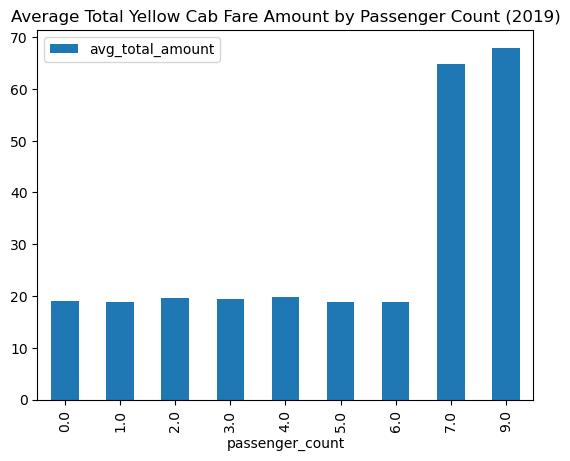

In [14]:
df.dropna() \
  .sort_values(by='passenger_count') \
  .plot(kind='bar', 
        x='passenger_count', 
        y='avg_total_amount',
        title='Average Total Yellow Cab Fare Amount by Passenger Count (2019)');

If you run multiple queries, you'll notice that the number of files in your S3 bucket piles up pretty quickly:

In [15]:
bucket = 'jclindaniel-uchicago-athena'
bucket_resource = s3_resource.Bucket(bucket)
[obj.key for obj in bucket_resource.objects.all()]

['41733f2e-a4a2-4223-bbfd-2b407ad9f752.txt',
 'b623d396-ffb3-4f35-be7e-2a6f0c4e13b7.csv',
 'b623d396-ffb3-4f35-be7e-2a6f0c4e13b7.csv.metadata',
 'd97d5634-2e4f-4606-9621-582647045ea8.csv',
 'd97d5634-2e4f-4606-9621-582647045ea8.csv.metadata',
 'f89f9f9d-12ce-4a42-a762-16beedb16976.txt']

You can quickly delete all of the files in your bucket so that you don't have to pay for them by running the following `cleanup` function (unless you want to keep them for further analysis):

In [16]:
def cleanup(bucket_name):
    bucket = s3_resource.Bucket(bucket_name)
    for item in bucket.objects.all():
        item.delete()
        
cleanup('jclindaniel-uchicago-athena')

And the bucket is now empty again!

In [17]:
bucket = 'jclindaniel-uchicago-athena'
bucket_resource = s3_resource.Bucket(bucket)
[obj.key for obj in bucket_resource.objects.all()]

[]